# Frequentism, Samples, and the Bootstrap.

New Latex commands are defined here. Doubleclick to see.

$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$
$\newcommand{\SampleAvg}{\frac{1}{N({S})} \sum_{s \in {S}}}$
$\newcommand{\indic}{\mathbb{1}}$
$\newcommand{\avg}{\overline}$
$\newcommand{\est}{\hat}$
$\newcommand{\trueval}[1]{#1^{*}}$
$\newcommand{\Gam}[1]{\mathrm{Gamma}#1}$

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## DATA AND MODELS

### Why do we do this? Lets get some data...

Forty-four babies -- a new record -- were born in one 24-hour period at
the Mater Mothers' Hospital in Brisbane, Queensland, Australia, on
December 18, 1997.  For each of the 44 babies, _The Sunday Mail_
recorded the time of birth, the sex of the child, and the birth weight
in grams. Also included is the number of minutes since midnight for
each birth.

REFERENCE:
Steele, S. (December 21, 1997), "Babies by the Dozen for Christmas:
24-Hour Baby Boom," _The Sunday Mail_ (Brisbane), p. 7.

"Datasets
and Stories" article "A Simple Dataset for Demonstrating Common
Distributions" in the _Journal of Statistics Education_ (Dunn 1999).

Columns

       1 -  8  Time of birth recorded on the 24-hour clock
       9 - 16  Sex of the child (1 = girl, 2 = boy)
      17 - 24  Birth weight in grams
      25 - 32  Number of minutes after midnight of each birth

In [2]:
df = pd.read_table("babyboom.dat.txt", header=None, sep='\s+', 
                   names=['24hrtime','sex','weight','minutes'])
df.head()

,24hrtime,sex,weight,minutes
0,5,1,3837,5
1,104,1,3334,64
2,118,2,3554,78
3,155,2,3838,115
4,257,2,3625,177


In [3]:
df.minutes.mean()

788.7272727272727

### What is data?

In labs before, you have seen datasets. As so in the example above. You have seen probability distributions of this data. Calculated means. Calculated standard deviations.

#### Pandas code for the week

We'll keep showing some different aspects of Pandas+Seaborn each week. For example, you can very easily calculate correlations

In [4]:
df.corr()

,24hrtime,sex,weight,minutes
24hrtime,1.000000,0.028027,0.075636,0.999840
sex,0.028027,1.000000,0.228751,0.031815
weight,0.075636,0.228751,1.000000,0.079616
minutes,0.999840,0.031815,0.079616,1.000000


Remember that this correlation is a statistic calculated only on this data...this sample of babies. I have not asked the question: what does this mean for the population of babies.

I'd thought that there would be a greater correlation between weight and sex, but apparently its not at all big for babies. Telles you Idont know much about babies :-). Here's a plot more tohelp you in future homework:

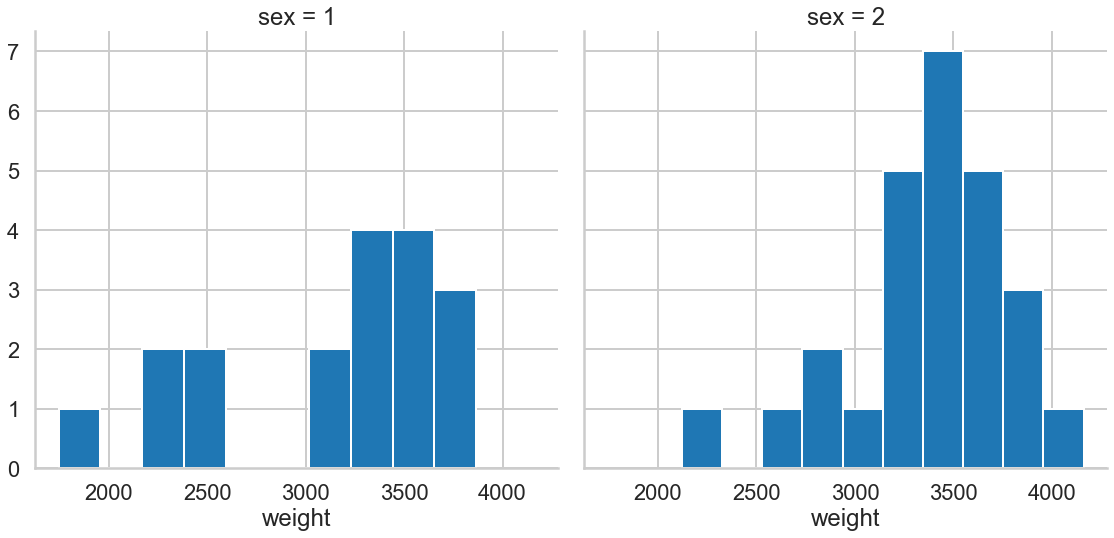

In [6]:
#g = sns.FacetGrid(col="sex", data=df, size=8)
g = sns.FacetGrid(col="sex", data=df, height=8)
g.map(plt.hist, "weight")

#### Samples vs population

But we have never aked ourselves the philosophical question: what is data? **Frequentist statistics** is one answer to this philosophical question. It treats data as a **sample** from an existing **population**.

This notion is probably clearest to you from elections, where some companies like Zogby or CNN take polls. The sample in these polls maybe a 1000 people, but they "represent" the electoral population at large. We attempt to draw inferences about how the population will vote based on these samples.

### Choosing a model

Let us characterize our particular sample statistically then, using a *probability distribution*


#### The Exponential Distribution

The exponential distribution occurs naturally when describing the lengths of the inter-arrival times in a homogeneous Poisson process.

It takes the form:
$$
f(x;\lambda) = \begin{cases}
\lambda e^{-\lambda x} & x \ge 0, \\
0 & x < 0.
\end{cases}
$$

From Wikipedia: *In probability theory, a Poisson process is a stochastic process which counts the number of events and the time that these events occur in a given time interval. The time between each pair of consecutive events has an exponential distribution with parameter $\lambda$ and each of these inter-arrival times is assumed to be independent of other inter-arrival times. The process is named after the French mathematician Siméon Denis Poisson and is a good model of radioactive decay, telephone calls and requests for a particular document on a web server, among many other phenomena.*

In our example above, we have the arrival times of the babies. There is no reason to expect any specific clustering in time, so one could think of modelling the arrival of the babies via a poisson process.

Furthermore, the Poisson distribution can be used to model the number of births each hour over the 24-hour period.

Text(0, 0.5, 'exponential pdf')

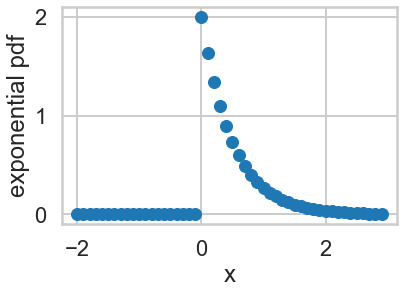

In [8]:
f = lambda x, l: l*np.exp(-l*x)*(x>0)
xpts=np.arange(-2,3,0.1)
plt.plot(xpts,f(xpts, 2),'o');
plt.xlabel("x")
plt.ylabel("exponential pdf")

Note: **some of the code, and ALL of the visual style for the distribution plots below was shamelessly stolen from https://gist.github.com/mattions/6113437/ **.

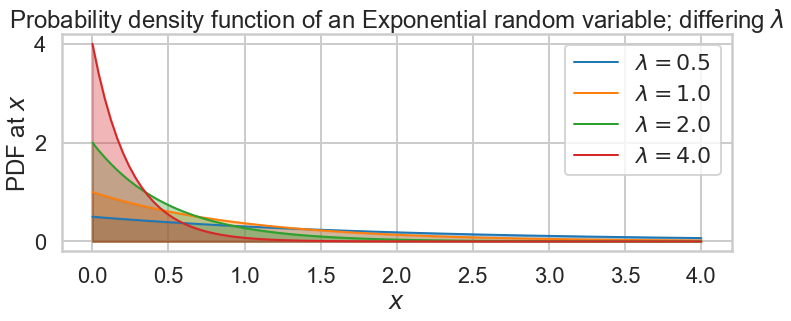

In [9]:
from scipy.stats import expon

x = np.linspace(0,4, 100)
colors=sns.color_palette()

lambda_ = [0.5, 1, 2, 4]
plt.figure(figsize=(12,4))
for l,c in zip(lambda_,colors):
    plt.plot(x, expon.pdf(x, scale=1./l), lw=2, 
                color=c, label = "$\lambda = %.1f$"%l)
    plt.fill_between(x, expon.pdf(x, scale=1./l), color=c, alpha = .33)
    
plt.legend()
plt.ylabel("PDF at $x$")
plt.xlabel("$x$")
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

### How would we draw from this distribution?

Lets use the built in machinery in `scipy.stats`:

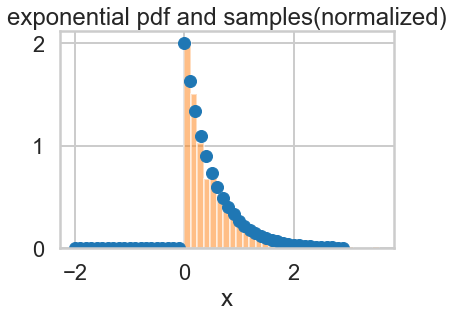

In [22]:
from scipy.stats import expon
plt.plot(xpts,expon.pdf(xpts, scale=1./2.),'o')
#plt.hist(expon.rvs(size=1000, scale=1./2.), normed=True, alpha=0.5, bins=30);
plt.hist(expon.rvs(size=1000, scale=1./2.), density=True, alpha=0.5, bins=30);

plt.xlabel("x")
plt.title("exponential pdf and samples(normalized)");

In `scipy.stats`, you can alternatively create a frozen object, which holds values of things like the scale

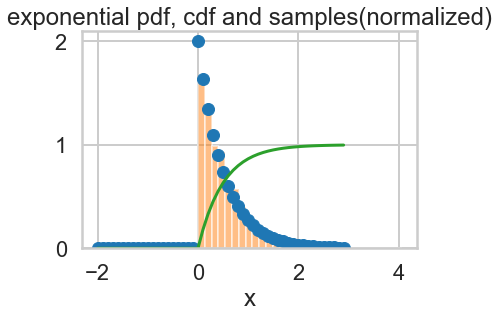

In [23]:
rv = expon(scale=0.5)
plt.plot(xpts,rv.pdf(xpts),'o')
#plt.hist(rv.rvs(size=1000), normed=True, alpha=0.5, bins=30);
plt.hist(rv.rvs(size=1000), density=True, alpha=0.5, bins=30);
plt.plot(xpts, rv.cdf(xpts));
plt.xlabel("x")
plt.title("exponential pdf, cdf and samples(normalized)");

### Understanding our data using a distribution

Lets play with our data a bit to understand it:

The first birth occurred at 0005, and the last birth in the 24-hour period at 2355. Thus the 43 inter-birth times happened over a 1430-minute period, giving a theoretical mean of 1430/43 = 33.26 minutes between births.

Lets plot a histogram of the inter-birth times

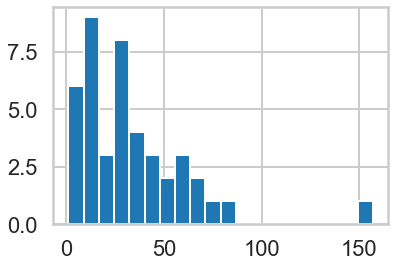

In [24]:
timediffs = df.minutes.diff()[1:]
timediffs.hist(bins=20);

The mean or of an exponentially distributed random variable X with rate parameter $\lambda$ can be analytically calculated as

$$\Ex[X] = \frac{1}{\lambda}.$$

This makes intuitive sense: if you get babies at an average rate of 2 per hour, then you can expect to wait half an hour for every baby.

The variance of X is given by

$$\Var[X] = \frac{1}{\lambda^2}.$$

so the standard deviatiation is equal to the mean, just as in the discrete Poisson distribution.

In [26]:
lambda_from_mean = 1./timediffs.mean()
print (lambda_from_mean, 1./lambda_from_mean)

0.03006993006993007 33.25581395348837


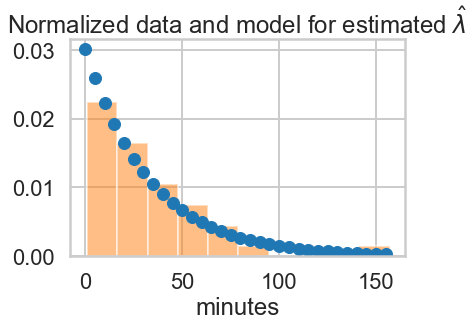

In [28]:
minutes=np.arange(0, 160, 5)
rv = expon(scale=1./lambda_from_mean)
plt.plot(minutes,rv.pdf(minutes),'o')
#timediffs.hist(normed=True, alpha=0.5);
timediffs.hist(density=True, alpha=0.5);
plt.xlabel("minutes");
plt.title("Normalized data and model for estimated $\hat{\lambda}$");

What did we just do? We made a 'point estimate' of the scale or rate parameter as a compression of our data. But what does it mean to make such a point estimate? The next section on **Frequentist Statistics** tells us. But first, lets see the Poisson Distribution.

#### An aside: The Poisson Distribution

The *Poisson Distribution* is defined for all positive integers: 

$$P(Z=k)=\frac{\lambda^k e^{−\lambda}}{k!}, k=0,1,2,... $$

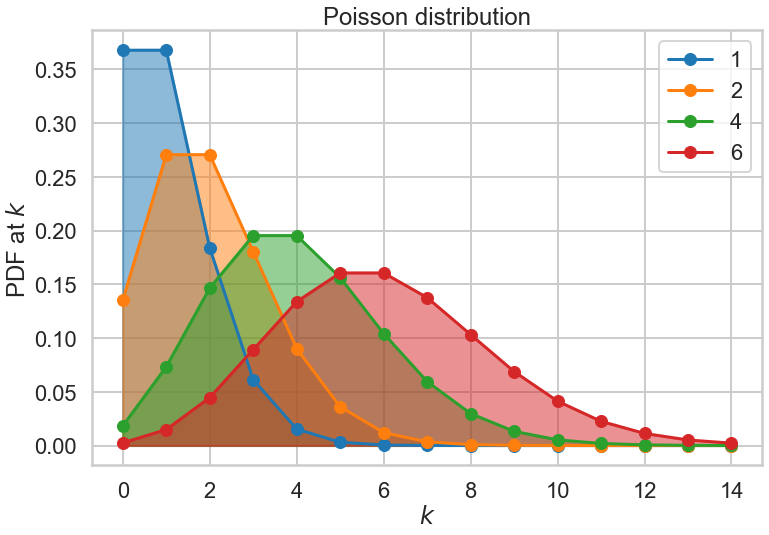

In [29]:
from scipy.stats import poisson
k = np.arange(15)
plt.figure(figsize=(12,8))
for i, lambda_ in enumerate([1, 2, 4, 6]):
    plt.plot(k, poisson.pmf(k, lambda_), '-o', label=lambda_, color=colors[i])
    plt.fill_between(k, poisson.pmf(k, lambda_), color=colors[i], alpha=0.5)
    plt.legend()
plt.title("Poisson distribution")
plt.ylabel("PDF at $k$")
plt.xlabel("$k$");

In [30]:
per_hour = df.minutes // 60
num_births_per_hour=df.groupby(per_hour).minutes.count()
num_births_per_hour

minutes
0     1
1     3
2     1
4     4
7     2
8     2
9     1
10    3
11    1
12    2
13    1
14    4
15    1
16    2
17    1
18    3
19    4
20    3
21    2
22    1
23    2
Name: minutes, dtype: int64

In [63]:
num_births_per_hour.mean()

2.0952380952380953

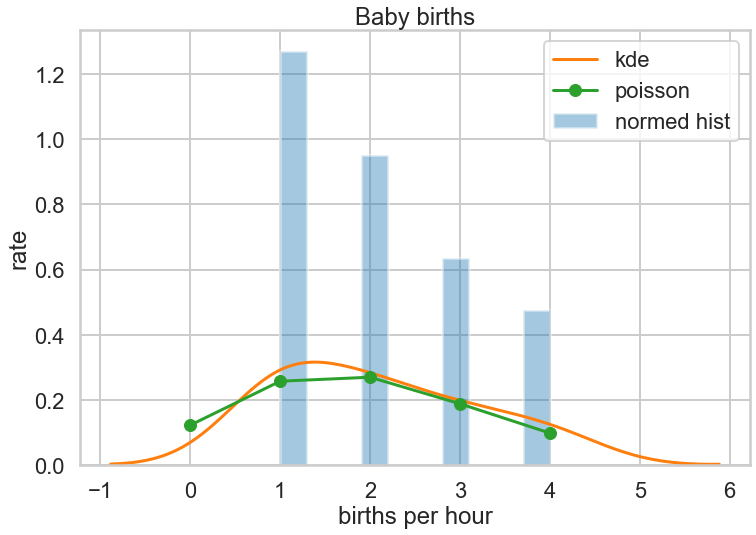

In [32]:
k = np.arange(5)
plt.figure(figsize=(12,8))
tcount=num_births_per_hour.sum()
#plt.hist(num_births_per_hour, alpha=0.4,  lw=3, normed=True, label="normed hist")
plt.hist(num_births_per_hour, alpha=0.4,  lw=3, density=True, label="normed hist")
sns.kdeplot(num_births_per_hour, label="kde")
plt.plot(k, poisson.pmf(k, num_births_per_hour.mean()), '-o',label="poisson")
plt.title("Baby births")
plt.xlabel("births per hour")
plt.ylabel("rate")
plt.legend();

### Maximum Likelihood Estimation

how did we know that the sample mean was a good thing to use?

One of the techniques used to estimate such parameters in frequentist statistics is **maximum likelihood estimation**. Briefly, the idea behind it is:

The product 

$$
L(\lambda) = \prod_{i=1}^n P(x_i | \lambda)
$$

gives us a measure of how likely it is to observe values $x_1,...,x_n$ given the parameters $\lambda$. Maximum likelihood fitting consists of choosing the appropriate "likelihood" function $L=P(X|\lambda)$ to maximize for a given set of observations. How likely are the observations if the model is true?

Often it is easier and numerically more stable to maximise the log likelyhood:

$$
\ell(\lambda) = \sum_{i=1}^n ln(P(x_i | \lambda))
$$

In the case of the exponential distribution we have:

$$
\ell(lambda) = \sum_{i=1}^n ln(\lambda e^{-\lambda x_i}) = \sum_{i=1}^n \left( ln(\lambda) - \lambda x_i \right).
$$

Maximizing this:

$$
\frac{d \ell}{d\lambda} = \frac{n}{\lambda} - \sum_{i=1}^n x_i = 0
$$

and thus:

$$
\est{\lambda_{MLE}} = \frac{1}{n}\sum_{i=1}^n x_i,
$$

which is identical to the simple estimator we used above. Usually one is not so lucky and one must use numerical optimization techniques.

A crucial property is that, for many commonly occurring situations, maximum likelihood parameter estimators have an approximate normal distribution when n is large. 

## FREQUENTIST STATISTICS 

In frequentist statistics, the data we have in hand, is viewed as a **sample** from a population. So if we want to estimate some parameter of the population, like say the mean, we estimate it on the sample.

This is because we've been given only one sample. Ideally we'd want to see the population, but we have no such luck.

The parameter estimate is computed by applying an estimator $F$ to some data $D$, so $\est{\lambda} = F(D)$. 


**The parameter is viewed as fixed and the data as random, which is the exact opposite of the Bayesian approach which you will learn later in this class. **

For the babies, lets assume that an exponential distribution is a good description of the baby arrival process. Then we consider some larger population of babies from which this sample is drawn, there is some true $\trueval{\lambda}$ which defines it. We dont know this. The best we can do to start with is to estimate  a lambda from the data set we have, which we denote $\est{\lambda}$. 

Now, imagine that I let you peek at the entire population in this way: I gave you some M data sets **drawn** from the population, and you can now find the mean on each such dataset, of which the one we have here is one.
So, we'd have M means. You can think of these means as coming from some fixed parameter by some data drawing process

Now if we had many replications of this data set: that is, data from other days, an **ensemble** of data sets, for example, we can compute other $\est{\lambda}$, and begin to construct the **sampling distribution** of $\lambda$.

### Segue: many samples on the binomial

In [18]:
from scipy.stats.distributions import bernoulli
def throw_a_coin(n):
    brv = bernoulli(0.5)
    return brv.rvs(size=n)

The function below returns the mean for each sample in an ensemble of samples

In [19]:
def make_throws(number_of_samples, sample_size):
    start=np.zeros((number_of_samples, sample_size), dtype=int)
    for i in range(number_of_samples):
        start[i,:]=throw_a_coin(sample_size)
    return np.mean(start, axis=1)

Let us now do 200 replications, each of which has a sample size of 1000 flips, and store the 200 means for each sample zise from 1 to 1000 in `sample_means`. This will rake some time to run as I am doing it for 200 replications at 1000 different sample sizes.

In [20]:
sample_sizes=np.arange(1,1001,1)
sample_means = [make_throws(number_of_samples=200, sample_size=i) for i in sample_sizes]

So remember that for eachsample size, i am getting 200 means. Lets get the mean of the means at each sample size.

In [23]:
mean_of_sample_means = [np.mean(means) for means in sample_means]

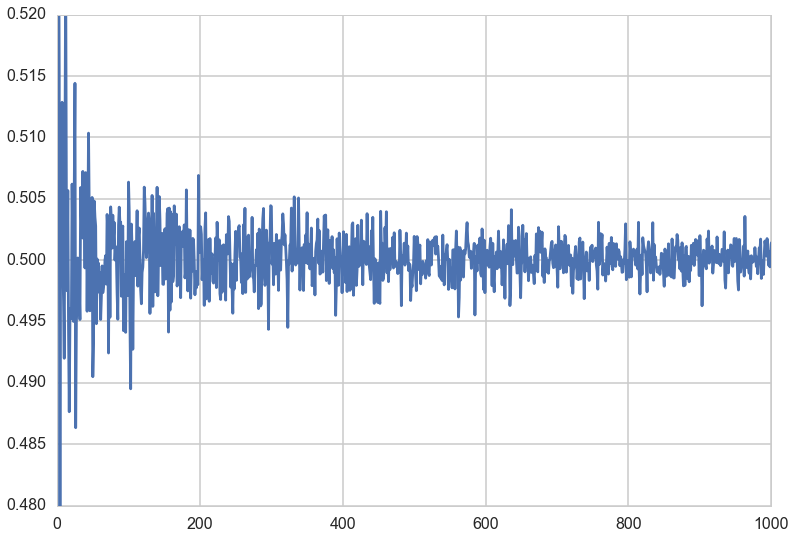

In [24]:
plt.plot(sample_sizes, mean_of_sample_means);
plt.ylim([0.480,0.520]);

Not surprisingly, the mean of the sample means converges to the distribution mean as the sample size N gets very large.

#### The notion of a Sampling Distribution

(some text is quoted from Murphy's machine learning book)

In data science, we are always interested in understanding the world from incomplete data, in other words from a sample or a few samples of a population at large. Our experience with the world tells us that even if we are able to repeat an experiment or process, we will get more or less different answers the next time. If all of the answers were very different each time, we would never be able to make any predictions.

But some kind of answers differ only a little, especially as we get to larger sample sizes. So the important question then becomes one of the distribution of these quantities from sample to sample, also known as a **sampling distribution**. 

Since, in the real world, we see only one sample, this distribution helps us do **inference**, or figure the uncertainty of the estimates of quantities we are interested in. If we can somehow cook up samples just somewhat different from the one we were given, we can calculate quantities of interest, such as the mean on each one of these samples. By seeing how these means vary from one sample to the other, we can say how typical the mean in the sample we were given is, and whats the uncertainty range of this quantity. This is why the mean of the sample means is an interesting quantity; it characterizes the **sampling distribution of the mean**, or the distribution of sample means.

So, in the babies case, the uncertainty in the parameter estimate can be measured by computing the **sampling distribution** of the estimator. 
What you are doing is sampling many Data Sets $D_i$ from the true population (which we are not given you will argue, and you are right, but just wait a bit), say M of them, each of size N, from some true model $p(\cdot|\trueval{\lambda})$. We will now calculate M $\est{\lambda}_i$, one for each dataset. As we let $M \rightarrow \infty$, the distribution induced on $\est{\lambda}$ is the sampling distribution of the estimator.

## Inference 

Just having an estimate is no good. We will want to put confidence intervals on the estimation of the parameters. This presents a conundrum: we have access to only one sample, but want to compute a error estimate over multiple samples, using an estimator such as the standard deviation.

At this point we are wishing for the Lord  to have given us those other samples drawn from the population that we talked about above. But alas, no such luck...

In the last two decades, **resampling** the ONE dataset we have has become computationally feasible. Resampling involves making new samples from the observations, each of which is analysed in the same way as out original dataset. One way to do this is the Bootstrap. 

### Bootstrap

Bootstrap tries to approximate our sampling distribution. If we knew the true parameters of the population, we could generate M fake datasets. Then we could compute the parameter (or another estimator) on each one of these, to get a empirical sampling distribution of the parameter or estimator, and which will give us an idea of how typical our sample is, and thus, how good our parameter estimations from our sample are.
(again from murphy)

But we dont have the true parameter. So we generate these samples, using the parameter we calculated. Or, alteratively, we sample with replacement the X from our original sample D, generating many fake datasets, and then compute the distribution on the parameters as before. 

We do it here for the mean of the time differences. We could also do it for its inverse, $\lambda$.

#### Non Parametric bootstrap

Resample the data! We can then plot the distribution of the mean time-difference.

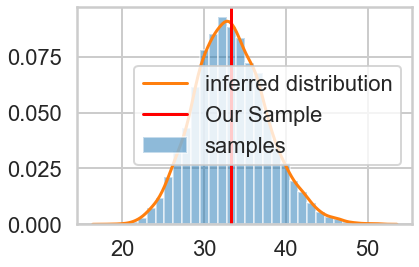

In [34]:
M_samples=10000
N_points = timediffs.shape[0]
bs_np = np.random.choice(timediffs, size=(M_samples, N_points))
sd_mean=np.mean(bs_np, axis=1)
sd_std=np.std(bs_np, axis=1)
#plt.hist(sd_mean, bins=30, normed=True, alpha=0.5,label="samples");
plt.hist(sd_mean, bins=30, density=True, alpha=0.5,label="samples");
sns.kdeplot(sd_mean, label="inferred distribution")
plt.axvline(timediffs.mean(), 0, 1, color='r', label='Our Sample')
plt.legend()

#### Parametric Bootstrap

And here we do it in a parametric way. We get an "estimate" of the parameter from our sample, and them use the exponential distribution to generate many datasets, and then fir the parameter on each one of those datasets. We can then plot the distribution of the mean time-difference.

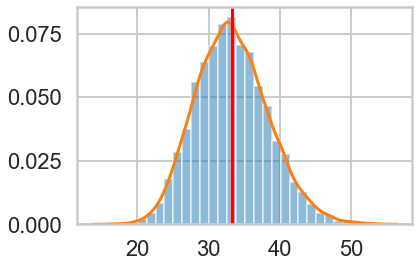

In [35]:
rv = expon(scale=1./lambda_from_mean)
M_samples=10000
N_points = timediffs.shape[0]
bs_p = rv.rvs(size=(M_samples, N_points))
sd_mean_p=np.mean(bs_p, axis=1)
sd_std_p=np.std(bs_p, axis=1)
#plt.hist(sd_mean_p, bins=30, normed=True, alpha=0.5);
plt.hist(sd_mean_p, bins=30, density=True, alpha=0.5);
sns.kdeplot(sd_mean_p);
plt.axvline(timediffs.mean(), 0, 1, color='r', label='Our Sample')